In [43]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from IPython.display import Markdown, display

In [44]:
def create_donut_charts(dataframes, column_names, titles=None):
    if titles is None:
        titles = column_names
        
    num_bar_charts = len(dataframes)
    fig, axs = plt.subplots(1, num_bar_charts, figsize=(7.5 * num_bar_charts, 6))

    for i, df in enumerate(dataframes):
        values = df[column_names[i]]
        labels = [*df.index]
        print(values)
        total = sum(values)
        axs[i].pie(
            values,
            labels=labels,
            # colors=colors,
            autopct=lambda p: f"{p:.0f}% ({p * total / 100:.0f})" if p > 0 else "0",
            startangle=140,
            wedgeprops=dict(width=0.25, edgecolor="w", linewidth=0.25),
            textprops=dict(color="black", fontsize=10),
        )
        axs[i].set_title(titles[i])
        axs[i].axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.tight_layout()
    # plt.show()
    return fig

from model.utils.seed import initialize_seed
from model.utils.reactions import determine_reaction_time_vector
from model.types.reaction_time import ReactionTime, ModeledReactions

def get_actor_category(**kwargs):
    # Get the length of the first boolean numpy array
    first_key = next(iter(kwargs))
    length = len(kwargs[first_key])
    
    # Create an array of strings initialized with a default value
    actor_category = np.array(['Normal'] * length)
    
    # Apply masks to set corresponding names
    for mask_name, mask in kwargs.items():
        actor_category[mask] = mask_name
    
    return actor_category

def get_abstaining_mask(wallet_df):
    actor_typestr = np.array(wallet_df.type)
    abstaining_mask = np.isin(actor_typestr, ['Contract', 'CEX', 'Custody'])
    return abstaining_mask

def get_institutional_mask(wallet_df, institutional_threshold: float = 3000):
    institutional_mask = wallet_df.total >= institutional_threshold
    return institutional_mask

def get_reaction_time_distribution(wallet_df, 
                                   reactions: ModeledReactions = ModeledReactions.Normal,
                                   institutional_threshold: float = 3000):
    reaction_time_vector = determine_reaction_time_vector(len(wallet_df), reactions)

    institutional_mask = get_institutional_mask(wallet_df, institutional_threshold)
    reaction_time_vector[institutional_mask] = ReactionTime.Slow.value

    abstaining_mask = get_abstaining_mask(wallet_df)
    reaction_time_vector[abstaining_mask] = ReactionTime.NoReaction.value

    actor_category = get_actor_category(
        Institutional=institutional_mask,
        Abstaining=abstaining_mask,
    )

    return reaction_time_vector, actor_category

def create_more_uniform_distribution(current_balances, uniformity_factor, mask=None):
    """
    Create a more uniform distribution of balances.
    
    Parameters:
    - current_balances: numpy array of current balances.
    - uniformity_factor: float, degree of uniformity (0 = original, 1 = completely uniform).
    - mask: numpy array of booleans, True for balances that should not be redistributed.
    
    Returns:
    - new_balances: numpy array of new balances.
    """
    if mask is None:
        mask = np.zeros_like(current_balances, dtype=bool)
    
    new_balances = current_balances.copy()
    
    # Calculate the total sum and uniform balance for non-masked wallets
    non_masked_balances = current_balances[~mask]
    total_non_masked_sum = np.sum(non_masked_balances)
    uniform_balance = total_non_masked_sum / len(non_masked_balances)
    
    # Blend the original and uniform distributions for non-masked wallets
    new_balances[~mask] = (
        (1 - uniformity_factor) * non_masked_balances + uniformity_factor * uniform_balance
    )
    
    # Adjust the new balances to ensure the total sum remains the same
    difference = total_non_masked_sum - np.sum(new_balances[~mask])
    new_balances[~mask][0] += difference  # Adjust the first non-masked element
    
    return new_balances

def create_less_uniform_distribution(current_balances, disparity_factor, mask=None):
    """
    Create a less uniform distribution of balances using the Rich-Get-Richer model.
    
    Parameters:
    - current_balances: numpy array of current balances.
    - disparity_factor: float, degree of disparity (0 = original, higher values increase disparity).
    - mask: numpy array of booleans, True for balances that should not be redistributed.
    
    Returns:
    - new_balances: numpy array of new balances.
    """
    if mask is None:
        mask = np.zeros_like(current_balances, dtype=bool)
    
    # Calculate the total sum for non-masked wallets
    non_masked_balances = current_balances[~mask]
    total_non_masked_sum = np.sum(non_masked_balances)
    
    # Calculate the proportion of the total sum to redistribute
    redistribute_proportion = disparity_factor * total_non_masked_sum
    
    # Calculate the additional amount to add to each non-masked balance
    additional_amount = (non_masked_balances / total_non_masked_sum) * redistribute_proportion
    
    # Create new balances by adding the additional amount to non-masked balances
    new_balances = current_balances.copy()
    new_balances[~mask] += additional_amount
    
    # Normalize to maintain the total sum for non-masked balances
    new_balances[~mask] = new_balances[~mask] / np.sum(new_balances[~mask]) * total_non_masked_sum
    
    return new_balances

def plot_token_share_distribution(wallet_df, redistribution_function, parameter_list, fig=None, **plot_kwargs):
    """
    Plot token share distribution by reaction time vs. a parameter from a redistribution function.
    
    Parameters:
    - wallet_df: DataFrame containing wallet data.
    - redistribution_function: function to redistribute balances.
    - parameter_list: list or array of parameters to test with the redistribution function.
    """
    results = []
    current_balances = wallet_df['total'].values
    
    for parameter in parameter_list:
        # Create a new distribution using the redistribution function
        new_balances = redistribution_function(current_balances, parameter)
        
        # Create a temporary DataFrame for the new distribution
        temp_df = wallet_df.copy()
        temp_df['total'] = new_balances
        temp_df['total_token_share'] = temp_df['total'] / temp_df['total'].sum() * 100
        
        # Calculate reaction time distribution
        reaction_time_distribution, _ = get_reaction_time_distribution(temp_df)
        
        # Store the results
        for reaction_time in np.unique(reaction_time_distribution):
            token_share = temp_df[temp_df['reaction_time'] == reaction_time]['total_token_share'].sum()
            reaction_time_enum = next(rt for rt in ReactionTime if rt.value == reaction_time)
            results.append({
                'Parameter': parameter,
                'ReactionTime': reaction_time_enum.name,
                'TokenShare': token_share
            })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Plot the results
    if fig is None:
        fig = plt.figure(figsize=(12, 8))
    ax = fig.gca()
    sns.lineplot(data=results_df, x='Parameter', y='TokenShare', hue='ReactionTime', marker='o', ax=ax, **plot_kwargs)
    
    ax.set_title('Token Share Distribution by Reaction Time vs. Parameter')
    ax.set_xlabel('Parameter')
    ax.set_ylabel('Token Share (%)')
    ax.legend(title='Reaction Time')

    return fig

In [45]:
outpath = Path('results/wallet_analysis')
outpath.mkdir(exist_ok=True)

wallet_df = pd.read_csv(Path('data/stETH token distribution  - stETH+wstETH holders.csv'))
wallet_df.loc[wallet_df.type.isna(), 'type'] = 'Other'
wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum() * 100

In [46]:
wallet_df['total'][(wallet_df['type'] == 'Private') | (wallet_df['type'] == 'No label')].sum() / wallet_df['total'].sum()

np.float64(0.3577268410230698)

In [51]:
total_balance = wallet_df[wallet_df['address'] != '0x91bef2fd282aaa7612c593c4d83c0efaf6200954'].total.sum()
print(total_balance)
def get_needed_balance(total_balance, target_share):
    x = total_balance * target_share / (1 - target_share)
    return x

for target_share in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
    print(target_share, get_needed_balance(total_balance, target_share))

8996374.567505062
0.25 2998791.522501687
0.3 3855589.100359312
0.35 4844201.690195033
0.4 5997583.045003375
0.45 7360670.10068596
0.5 8996374.567505062
0.55 10995568.915839521
0.6 13494561.85125759


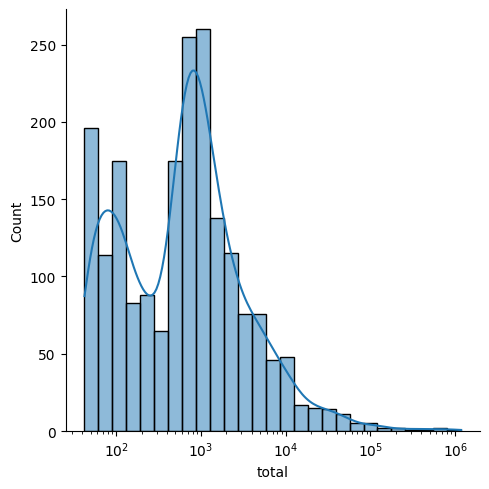

In [5]:
sns.displot(wallet_df.total, log_scale=True, kde=True)

In [37]:
initialize_seed(1)
reaction_time_distribution, actor_category = get_reaction_time_distribution(wallet_df)
wallet_df['reaction_time'] = reaction_time_distribution
wallet_df.groupby('reaction_time').total_token_share.sum()

reaction_time
1     1.539054
2     0.228779
3    34.004851
4    64.227316
Name: total_token_share, dtype: float64

In [7]:
print(np.unique(reaction_time_distribution, return_counts=True))

(array([1, 2, 3, 4], dtype=int8), array([ 210,   41, 1553,  182]))


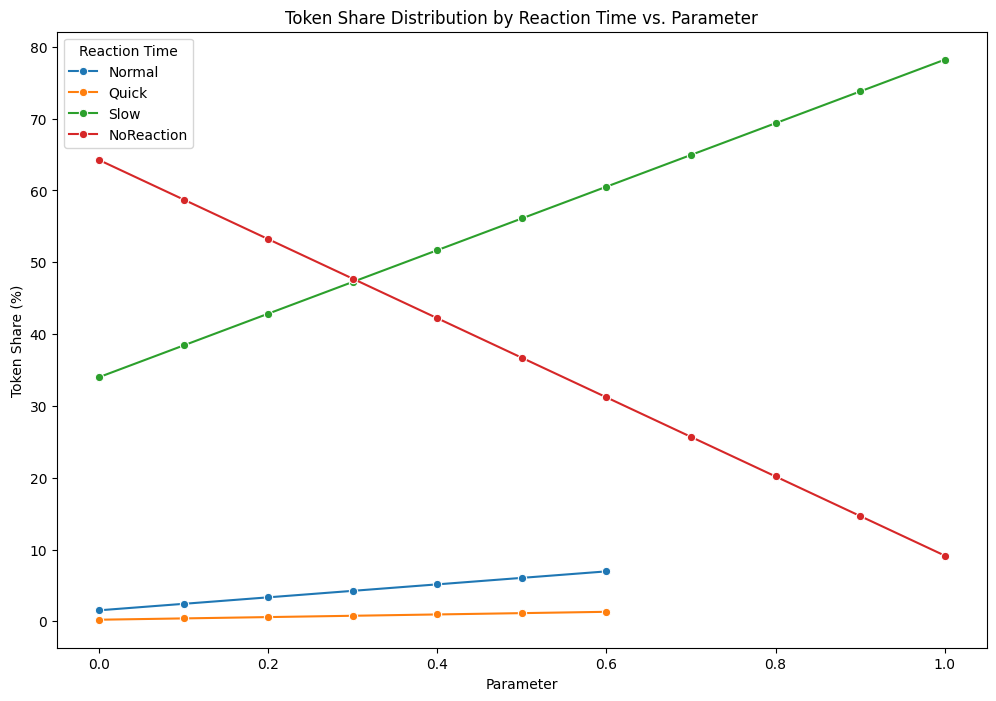

In [8]:
# Example usage
uniformity_factors = np.linspace(0, 1, 11)
abstaining_mask = get_abstaining_mask(wallet_df)
abstaining_mask[:] = False
fig = plot_token_share_distribution(wallet_df, lambda balances, factor: create_more_uniform_distribution(balances, factor, abstaining_mask), uniformity_factors)

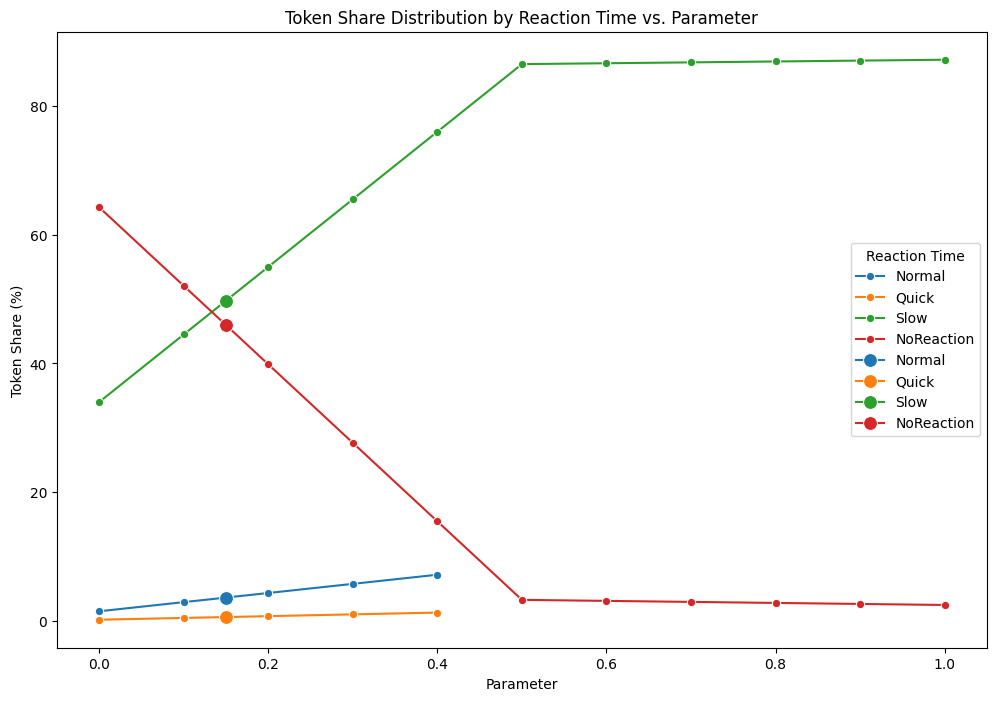

In [9]:
def redistribute_balances(balances, types,redistribution_factor, redistribution_rates_dict=None):
    """
    Redistribute balances by taking a percentage from specific wallet types (Contract, CEX, Custody) and redistributing to others.
    
    Parameters:
    - wallet_df: DataFrame containing wallet data with 'total' and 'type' columns.
    - redistribution_factor: float, factor to multiply the redistribution rates by.
    - redistribution_rates_dict: dictionary of redistribution rates for each wallet type.
    
    Returns:
    - new_balances: numpy array of new balances.
    """

    if redistribution_rates_dict is None:
        redistribution_rates_dict = {
            'Contract': 2,
            'CEX': 1,
            'Custody': 0,
        }
    contract_percentage = min(redistribution_rates_dict['Contract'] * redistribution_factor, 1)
    cex_percentage = min(redistribution_rates_dict['CEX'] * redistribution_factor, 1)
    custody_percentage = min(redistribution_rates_dict['Custody'] * redistribution_factor, 1)


    current_balances = balances
    new_balances = current_balances.copy()
    
    # Create masks for different wallet types
    contract_mask = types == 'Contract'
    cex_mask = types == 'CEX'
    custody_mask = types == 'Custody'
    other_mask = ~(contract_mask | cex_mask | custody_mask)  # All other types

    # Calculate the total amount to redistribute
    contract_amount = np.sum(current_balances[contract_mask]) * contract_percentage
    cex_amount = np.sum(current_balances[cex_mask]) * cex_percentage
    custody_amount = np.sum(current_balances[custody_mask]) * custody_percentage
    total_redistribute_amount = contract_amount + cex_amount + custody_amount

    # Subtract the redistribution amounts from the respective wallet types
    new_balances[contract_mask] -= current_balances[contract_mask] * contract_percentage
    new_balances[cex_mask] -= current_balances[cex_mask] * cex_percentage
    new_balances[custody_mask] -= current_balances[custody_mask] * custody_percentage

    # Redistribute the total amount evenly to other wallets
    num_other_wallets = np.sum(other_mask)
    if num_other_wallets > 0:
        redistribute_per_wallet = total_redistribute_amount / num_other_wallets
        new_balances[other_mask] += redistribute_per_wallet

    return new_balances

# Example usage
redistribution_factors = np.linspace(0, 1, 11)
fig = plot_token_share_distribution(wallet_df, lambda balances, factor: redistribute_balances(balances, wallet_df.type, factor), redistribution_factors)
ax = fig.gca()

plot_kwargs = {'markersize': 10}
fig = plot_token_share_distribution(wallet_df, lambda balances, factor: redistribute_balances(balances, wallet_df.type, factor), [0.15], fig=fig, **plot_kwargs)

In [40]:
redistribution_factor = 0.15
new_stETH = redistribute_balances(wallet_df.stETH.values, wallet_df.type.values, redistribution_factor)
new_wstETH = redistribute_balances(wallet_df.wstETH.values, wallet_df.type.values, redistribution_factor)

wallet_df_new = wallet_df.copy()
wallet_df_new['stETH'] = new_stETH
wallet_df_new['wstETH'] = new_wstETH
wallet_df_new['total'] = wallet_df_new['stETH'] + wallet_df_new['wstETH']
wallet_df_new['total_token_share'] = wallet_df_new['total'] / wallet_df_new['total'].sum() * 100
reaction_time_distribution_new, actor_category_new = get_reaction_time_distribution(wallet_df_new)
wallet_df_new['reaction_time'] = reaction_time_distribution_new
wallet_df_new.to_csv('data/decentralized_wallet_distribution.csv')

In [41]:
wallet_df_new.groupby('reaction_time').total_token_share.sum() / wallet_df.groupby('reaction_time').total_token_share.sum()

reaction_time
1    2.190185
2    2.184244
3    1.475585
4    0.715465
Name: total_token_share, dtype: float64

In [42]:
wallet_df_new['total'][(wallet_df_new['type'] == 'Private') | (wallet_df_new['type'] == 'No label')].sum() / wallet_df_new['total'].sum()

np.float64(0.5404758607889025)

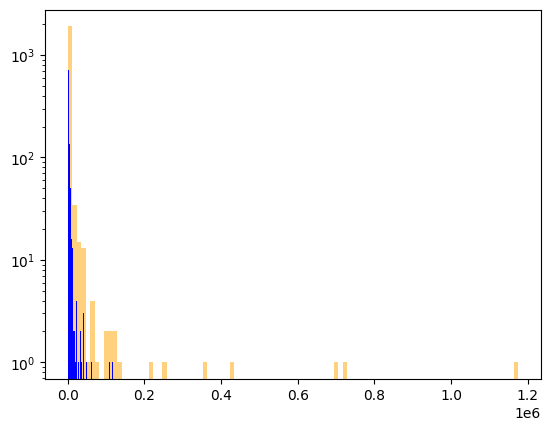

In [27]:
plt.hist(wallet_df.total, bins=100, log=True, alpha=0.5, zorder=1, color='orange');
plt.hist(wallet_df_new.total, bins=100, log=True, zorder=2, color='blue');


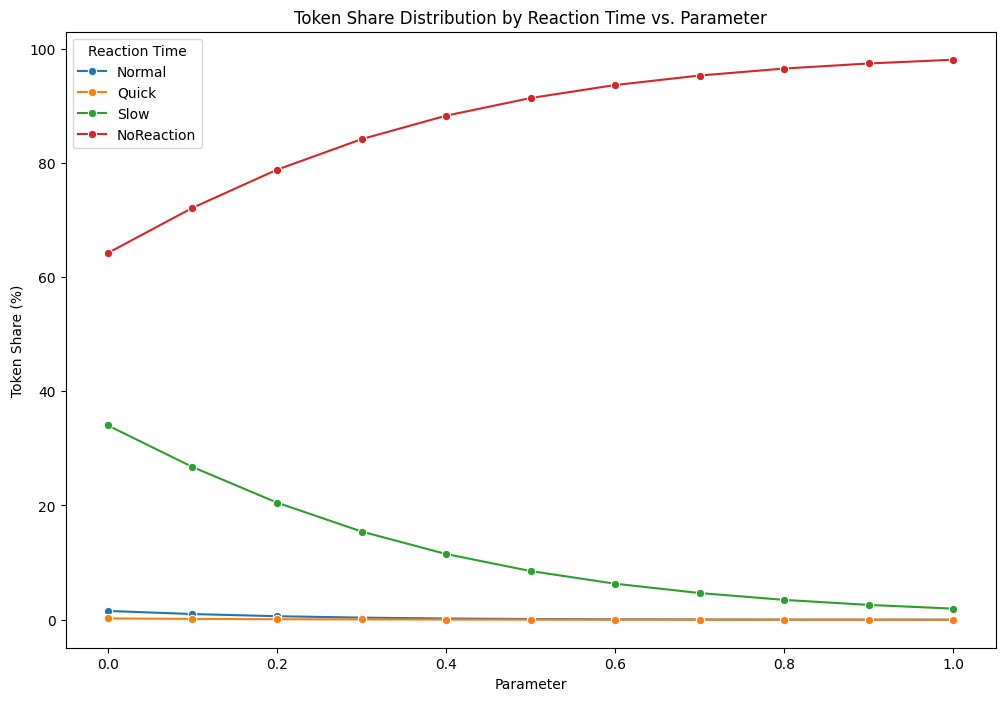

In [89]:
def create_less_uniform_distribution(current_balances, disparity_factor, mask=None):
    """
    Create a less uniform distribution of balances using an exponential transformation.
    
    Parameters:
    - current_balances: numpy array of current balances.
    - disparity_factor: float, degree of disparity (0 = original, higher values increase disparity).
    - mask: numpy array of booleans, True for balances that should not be redistributed.
    
    Returns:
    - new_balances: numpy array of new balances.
    """
    if mask is None:
        mask = np.zeros_like(current_balances, dtype=bool)
    
    # Calculate the total sum for non-masked wallets
    non_masked_balances = current_balances[~mask]
    total_non_masked_sum = np.sum(non_masked_balances)
    
    # Apply an exponential transformation to increase disparity for non-masked balances
    transformed_balances = np.power(non_masked_balances + 1, 1 + disparity_factor)
    
    # Normalize to maintain the total sum for non-masked balances
    new_non_masked_balances = transformed_balances / np.sum(transformed_balances) * total_non_masked_sum
    
    # Create the final new balances array
    new_balances = current_balances.copy()
    new_balances[~mask] = new_non_masked_balances
    
    return new_balances

# Test the function
disparity_factors = np.linspace(0, 1, 11)
abstaining_mask = get_abstaining_mask(wallet_df)
abstaining_mask[:] = False
fig = plot_token_share_distribution(wallet_df, lambda balances, factor: create_less_uniform_distribution(balances, factor, abstaining_mask), disparity_factors)

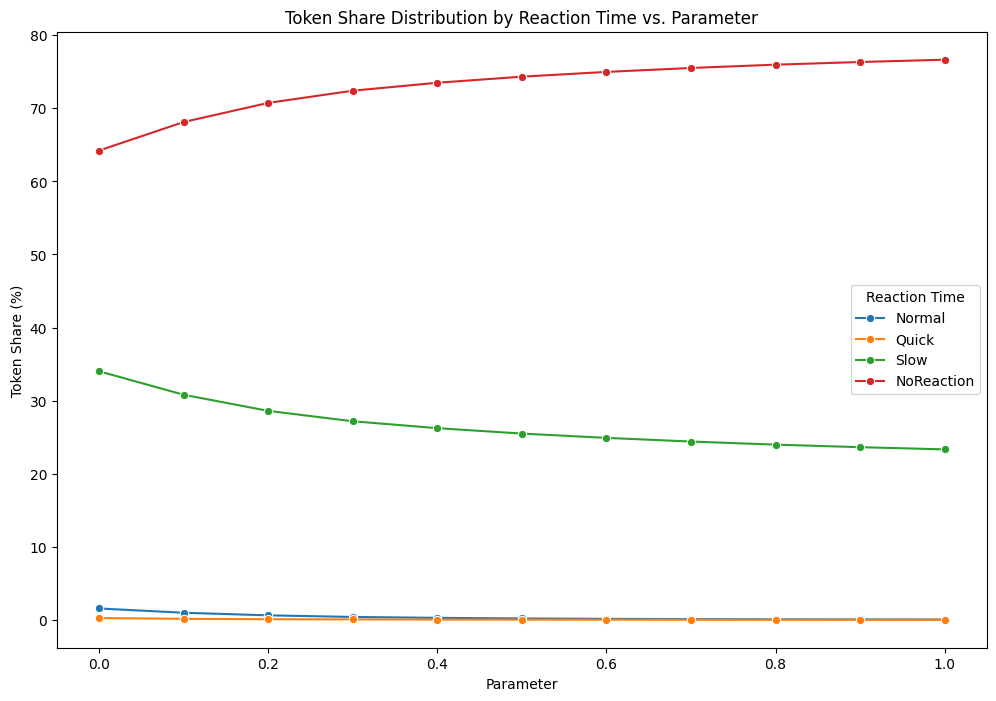

In [96]:
def create_less_uniform_distribution_linear(current_balances, disparity_factor, mask=None):
    """
    Create a less uniform distribution of balances using a linear redistribution approach.
    
    Parameters:
    - current_balances: numpy array of current balances.
    - disparity_factor: float, degree of disparity (0 = original, higher values increase disparity).
    - mask: numpy array of booleans, True for balances that should not be redistributed.
    
    Returns:
    - new_balances: numpy array of new balances.
    """
    if mask is None:
        mask = np.zeros_like(current_balances, dtype=bool)
    
    # Calculate the total sum for non-masked wallets
    non_masked_balances = current_balances[~mask]
    total_non_masked_sum = np.sum(non_masked_balances)
    
    # Calculate the mean balance
    mean_balance = total_non_masked_sum / len(non_masked_balances)
    
    # Create a new array for the redistributed balances
    new_non_masked_balances = non_masked_balances.copy()
    
    # Redistribute balances: take from below-average and give to above-average
    for i, balance in enumerate(non_masked_balances):
        if balance < mean_balance:
            # Reduce below-average balances, ensuring they don't go negative
            reduction = min((mean_balance - balance) * disparity_factor, balance)
            new_non_masked_balances[i] -= reduction
        else:
            # Increase above-average balances
            increase = (balance - mean_balance) * disparity_factor
            new_non_masked_balances[i] += increase
    
    # Normalize to maintain the total sum for non-masked balances
    new_non_masked_balances = new_non_masked_balances / np.sum(new_non_masked_balances) * total_non_masked_sum
    
    # Create the final new balances array
    new_balances = current_balances.copy()
    new_balances[~mask] = new_non_masked_balances
    
    return new_balances

# Test the function
disparity_factors = np.linspace(0, 1, 11)
abstaining_mask = get_abstaining_mask(wallet_df)
abstaining_mask[:] = False
fig = plot_token_share_distribution(wallet_df, lambda balances, factor: create_less_uniform_distribution_linear(balances, factor, abstaining_mask), disparity_factors)

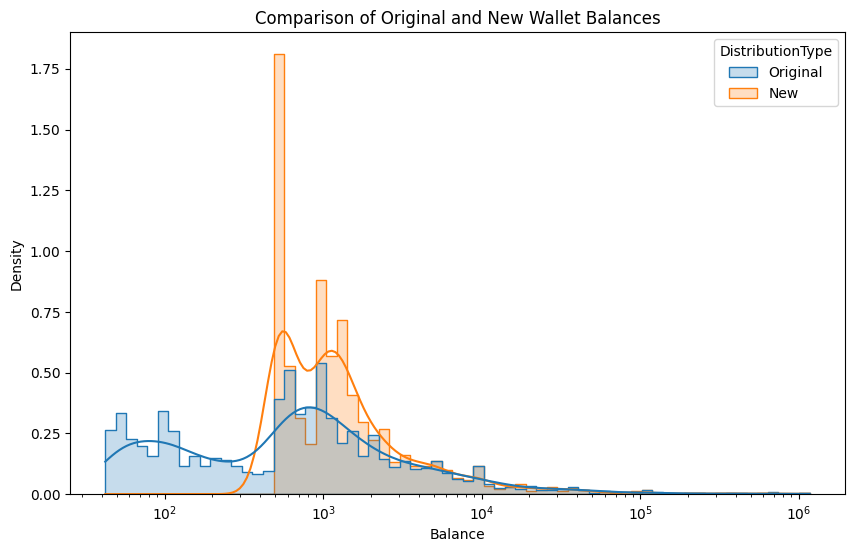

In [36]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Balance': np.concatenate([wallet_df['total'], wallet_df['new_total']]),
    'DistributionType': ['Original'] * len(wallet_df) + ['New'] * len(wallet_df)
})

# Plot the distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_df, x='Balance', hue='DistributionType', log_scale=True, kde=True, element='step', stat='density')

plt.title('Comparison of Original and New Wallet Balances')
plt.xlabel('Balance')
plt.ylabel('Density')
# plt.legend(title='Distribution Type')
plt.show()

In [39]:
wallet_df_uniform = wallet_df.copy()
wallet_df_uniform['total'] = new_balances
wallet_df_uniform['total_token_share'] = wallet_df_uniform['total'] / wallet_df_uniform['total'].sum() * 100

reaction_time_distribution_uniform, actor_category_uniform = get_reaction_time_distribution(wallet_df_uniform)
print(np.unique(reaction_time_distribution_uniform, return_counts=True))

(array([1, 2, 3, 4], dtype=int8), array([ 200,   32, 1572,  182]))


In [47]:
wallet_df_uniform['reaction_time'] = reaction_time_distribution_uniform
print(wallet_df_uniform[wallet_df_uniform['reaction_time'] == 2].total_token_share.sum())
print(wallet_df[wallet_df['reaction_time'] == 2].total_token_share.sum())


0.38220844955381117
0.22877897645459788


In [48]:
print(wallet_df_uniform[wallet_df_uniform['reaction_time'] == 1].total_token_share.sum())
print(wallet_df[wallet_df['reaction_time'] == 1].total_token_share.sum())

2.289370977593514
1.5390537025034854


In [49]:
print(wallet_df_uniform[wallet_df_uniform['reaction_time'] == 3].total_token_share.sum())
print(wallet_df[wallet_df['reaction_time'] == 3].total_token_share.sum())

38.60742136059864
34.004851423348896


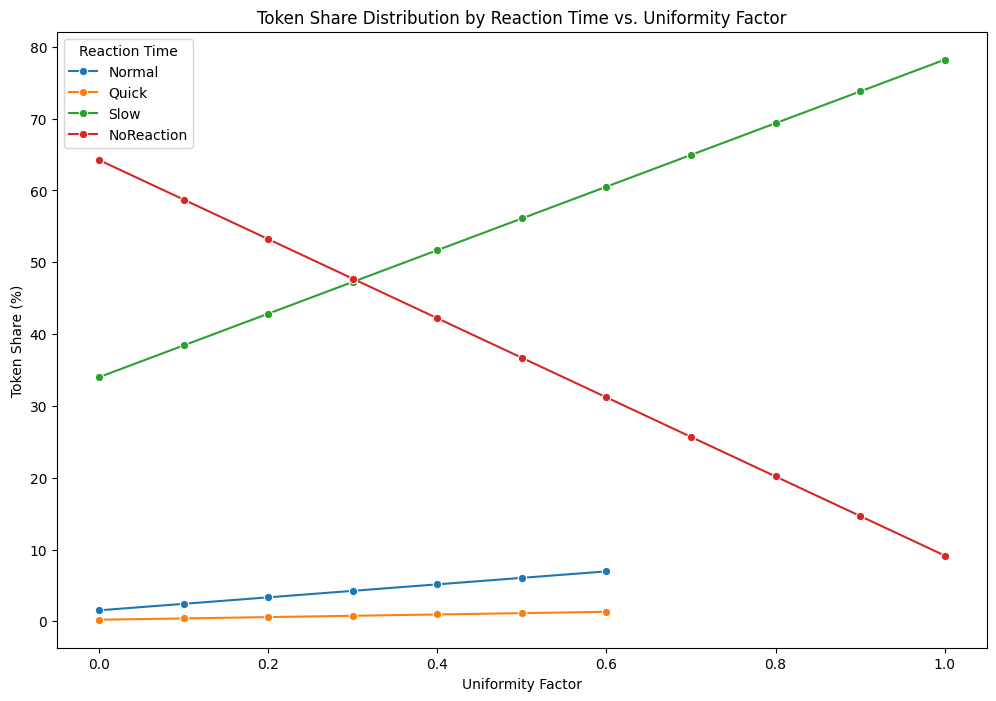

In [51]:
# Define a range of uniformity factors
uniformity_factors = np.linspace(0, 1, 11)  # From 0 to 1 in steps of 0.1

# Prepare a DataFrame to store results
results = []

reaction_time_names = {
    1: 'Normal',
    2: 'Quick',
    3: 'Slow',
    4: 'NoReaction'
}

for uniformity_factor in uniformity_factors:
    # Create a new distribution by blending the original and uniform distributions
    new_balances = (1 - uniformity_factor) * current_balances + uniformity_factor * uniform_balance

    # Adjust the new balances to ensure the total sum remains the same
    difference = total_sum - np.sum(new_balances)
    new_balances[0] += difference  # Adjust the first element to correct the total sum

    # Create a temporary DataFrame for the new distribution
    temp_df = wallet_df.copy()
    temp_df['total'] = new_balances
    temp_df['total_token_share'] = temp_df['total'] / temp_df['total'].sum() * 100

    # Calculate reaction time distribution
    reaction_time_distribution, _ = get_reaction_time_distribution(temp_df)

    # Store the results
    for reaction_time in np.unique(reaction_time_distribution):
        token_share = temp_df[temp_df['reaction_time'] == reaction_time]['total_token_share'].sum()
        results.append({
            'UniformityFactor': uniformity_factor,
            'ReactionTime': reaction_time_names[reaction_time],
            'TokenShare': token_share
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='UniformityFactor', y='TokenShare', hue='ReactionTime', marker='o')

plt.title('Token Share Distribution by Reaction Time vs. Uniformity Factor')
plt.xlabel('Uniformity Factor')
plt.ylabel('Token Share (%)')
plt.legend(title='Reaction Time')
plt.show()

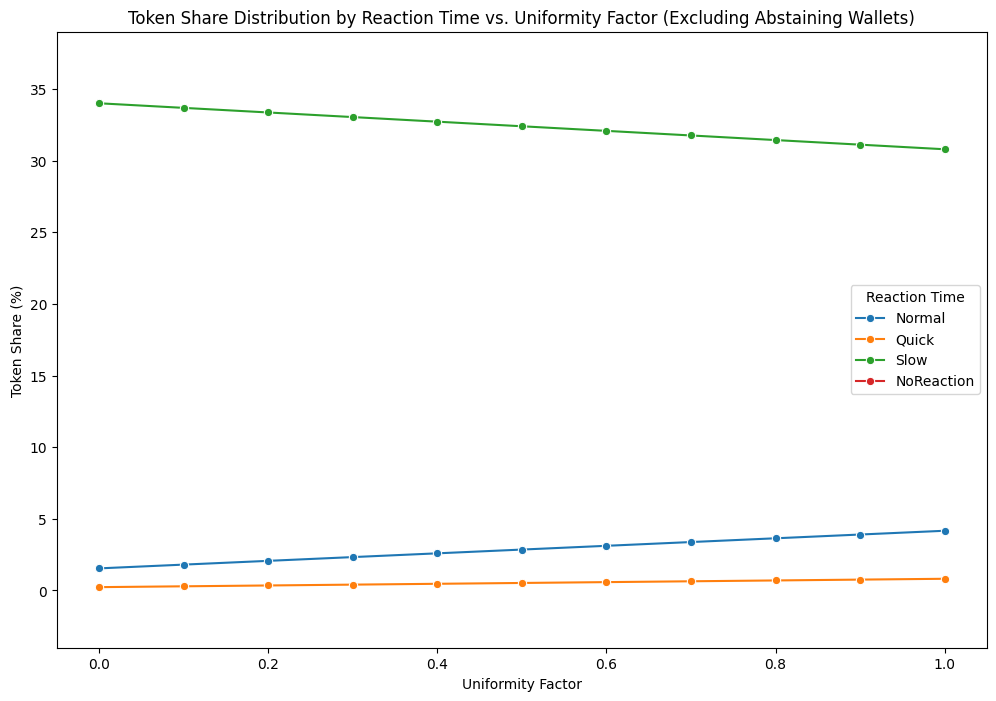

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a range of uniformity factors
uniformity_factors = np.linspace(0, 1, 11)  # From 0 to 1 in steps of 0.1

# Prepare a DataFrame to store results
results = []

# Get the abstaining mask
abstaining_mask = get_abstaining_mask(wallet_df)

for uniformity_factor in uniformity_factors:
    # Create a new distribution by blending the original and uniform distributions
    new_balances = current_balances.copy()
    
    # Calculate the total sum and uniform balance for non-abstaining wallets
    non_abstaining_balances = current_balances[~abstaining_mask]
    total_non_abstaining_sum = np.sum(non_abstaining_balances)
    uniform_balance = total_non_abstaining_sum / len(non_abstaining_balances)
    
    # Blend the original and uniform distributions for non-abstaining wallets
    new_balances[~abstaining_mask] = (
        (1 - uniformity_factor) * non_abstaining_balances + uniformity_factor * uniform_balance
    )
    
    # Adjust the new balances to ensure the total sum remains the same
    difference = total_non_abstaining_sum - np.sum(new_balances[~abstaining_mask])
    new_balances[~abstaining_mask][0] += difference  # Adjust the first non-abstaining element

    # Create a temporary DataFrame for the new distribution
    temp_df = wallet_df.copy()
    temp_df['total'] = new_balances
    temp_df['total_token_share'] = temp_df['total'] / temp_df['total'].sum() * 100

    # Calculate reaction time distribution
    reaction_time_distribution, _ = get_reaction_time_distribution(temp_df)

    # Store the results
    for reaction_time in np.unique(reaction_time_distribution):
        token_share = temp_df[temp_df['reaction_time'] == reaction_time]['total_token_share'].sum()
        results.append({
            'UniformityFactor': uniformity_factor,
            'ReactionTime': reaction_time_names[reaction_time],
            'TokenShare': token_share
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(12, 8))
sns.lineplot(data=results_df, x='UniformityFactor', y='TokenShare', hue='ReactionTime', marker='o')

plt.title('Token Share Distribution by Reaction Time vs. Uniformity Factor (Excluding Abstaining Wallets)')
plt.xlabel('Uniformity Factor')
plt.ylabel('Token Share (%)')
plt.legend(title='Reaction Time')
plt.ylim(-4, 39)
plt.show()